# import file


In [1]:
import os
import math
import torch
import torch.nn as nn
import numpy as np
from torch.utils.data import Dataset, DataLoader
from tokenizers import ByteLevelBPETokenizer
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import pandas as pd

c:\Users\Jim\anaconda3\Lib\site-packages\sklearn\utils\_param_validation.py:14: UserWarning: A NumPy version >=1.22.4 and <2.3.0 is required for this version of SciPy (detected version 2.3.0)
  from scipy.sparse import csr_matrix, issparse


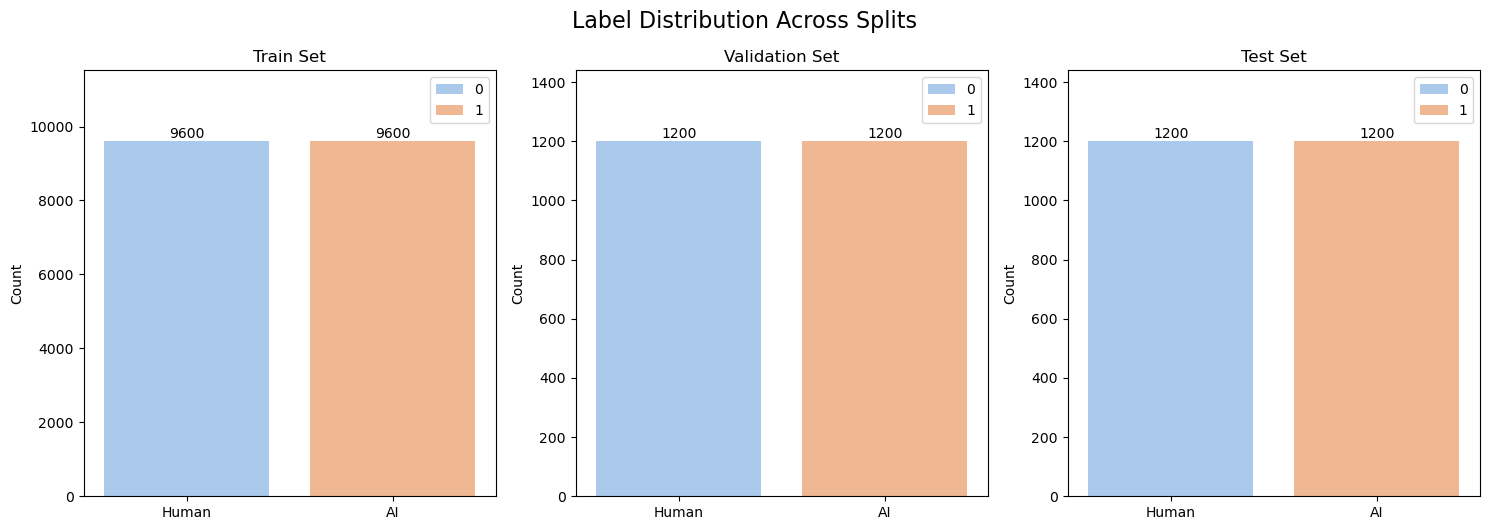

In [2]:
from transformers.utils import logging
logging.set_verbosity_error()

import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Load dataset
df = pd.read_csv("../Final_Dataset_Fixed.csv")

# Encode labels: human=0, ai=1
df['label'] = df['label'].map({'human': 0, 'ai': 1})

# Split into train, validation, test
train_texts, temp_texts, train_labels, temp_labels = train_test_split(
    df['text'].tolist(), df['label'].tolist(),
    test_size=0.2, stratify=df['label'], random_state=42
)

val_texts, test_texts, val_labels, test_labels = train_test_split(
    temp_texts, temp_labels,
    test_size=0.5, stratify=temp_labels, random_state=42
)

# --- Plot class distributions ---
splits = {
    "Train": train_labels,
    "Validation": val_labels,
    "Test": test_labels,
}

fig, axs = plt.subplots(1, 3, figsize=(15, 5))
for i, (split_name, split_labels) in enumerate(splits.items()):
    counts = pd.Series(split_labels).value_counts().sort_index()
    class_names = ['Human', 'AI']
    sns.barplot(x=class_names, y=counts.values, ax=axs[i], palette="pastel", hue=[0, 1])
    axs[i].set_title(f"{split_name} Set")
    axs[i].set_ylabel("Count")
    axs[i].set_ylim(0, max(counts.values) * 1.2)
    for j, count in enumerate(counts.values):
        axs[i].text(j, count + 2, str(count), ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.suptitle("Label Distribution Across Splits", fontsize=16, y=1.05)
plt.savefig("Label Distribution.png")
plt.show()


In [3]:
from transformers import AutoTokenizer, T5ForSequenceClassification
import torch

# Use mT5-small for classification
model_name = "google/mt5-small"

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = T5ForSequenceClassification.from_pretrained(model_name, num_labels=2)

# Tokenize datasets
train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=128)
val_encodings = tokenizer(val_texts, truncation=True, padding=True, max_length=128)
test_encodings = tokenizer(test_texts, truncation=True, padding=True, max_length=128)

# Dataset class
class BengaliDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels
    def __len__(self):
        return len(self.labels)
    def __getitem__(self, idx):
        return {
            key: torch.tensor(val[idx]) for key, val in self.encodings.items()
        } | {'labels': torch.tensor(self.labels[idx])}

train_dataset = BengaliDataset(train_encodings, train_labels)
val_dataset = BengaliDataset(val_encodings, val_labels)
test_dataset = BengaliDataset(test_encodings, test_labels)


c:\Users\Jim\anaconda3\Lib\site-packages\transformers\convert_slow_tokenizer.py:564: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


In [4]:
import transformers
print(transformers.__version__)


4.56.2


## Training

In [5]:
from transformers import TrainingArguments, Trainer, DataCollatorForSeq2Seq
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import numpy as np
import torch

# --- Metrics function ---
def compute_metrics(eval_pred):
    logits, labels = eval_pred

    # Hugging Face sometimes returns a tuple (logits,) instead of a plain array
    if isinstance(logits, (tuple, list)):
        logits = logits[0]

    preds = np.argmax(logits, axis=-1)
    acc = accuracy_score(labels, preds)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average="binary")
    return {"accuracy": acc, "precision": precision, "recall": recall, "f1": f1}

# --- Training args ---
output_dir = "./mt5-small_results"
training_args = TrainingArguments(
    output_dir=output_dir,
    num_train_epochs=3,
    per_device_train_batch_size=2,
    per_device_eval_batch_size=2,
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    weight_decay=0.01,
    report_to="none",
    seed=42,
    disable_tqdm=False,
)

from transformers import DataCollatorWithPadding

data_collator = DataCollatorWithPadding(
    tokenizer=tokenizer,
    return_tensors="pt"
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)

# --- Train the model ---
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.742500,0.649979,0.640417,0.762053,0.408333,0.531742
2,0.692300,1.009041,0.584583,0.839465,0.209167,0.334890
3,0.692000,0.974592,0.679167,0.901119,0.402500,0.556452


TrainOutput(global_step=28800, training_loss=0.7089409891764323, metrics={'train_runtime': 3910.0907, 'train_samples_per_second': 14.731, 'train_steps_per_second': 7.366, 'total_flos': 1960812881510400.0, 'train_loss': 0.7089409891764323, 'epoch': 3.0})

In [8]:
import json

# Save logs at the end of training
with open("training_logs.json", "w") as f:
    json.dump(trainer.state.log_history, f)


In [4]:
import json

with open("training_logs.json", "r") as f:
    logs = json.load(f)


In [5]:
from transformers import TrainingArguments, Trainer, DataCollatorForSeq2Seq
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import numpy as np
import torch

# --- Metrics function ---
def compute_metrics(eval_pred):
    logits, labels = eval_pred

    # Hugging Face sometimes returns a tuple (logits,) instead of a plain array
    if isinstance(logits, (tuple, list)):
        logits = logits[0]

    preds = np.argmax(logits, axis=-1)
    acc = accuracy_score(labels, preds)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average="binary")
    return {"accuracy": acc, "precision": precision, "recall": recall, "f1": f1}

# --- Training args ---
output_dir = "./mt5-small_results"
training_args = TrainingArguments(
    output_dir=output_dir,
    num_train_epochs=3,
    per_device_train_batch_size=2,
    per_device_eval_batch_size=2,
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    weight_decay=0.01,
    report_to="none",
    seed=42,
    disable_tqdm=False,
)

from transformers import DataCollatorWithPadding

data_collator = DataCollatorWithPadding(
    tokenizer=tokenizer,
    return_tensors="pt"
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)

# Plots: Training/Validation Loss & Accuracy

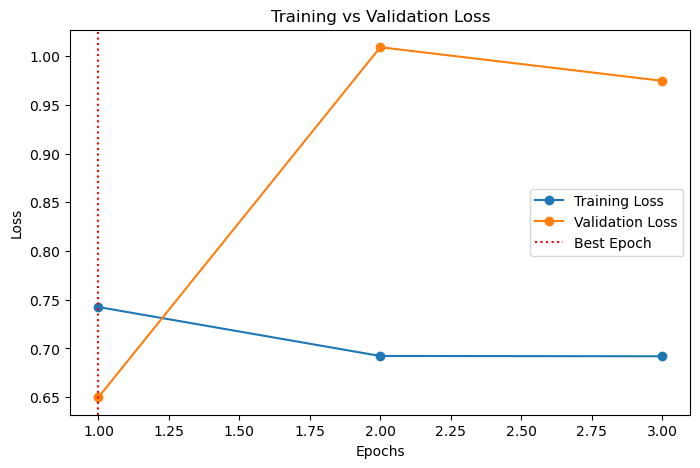

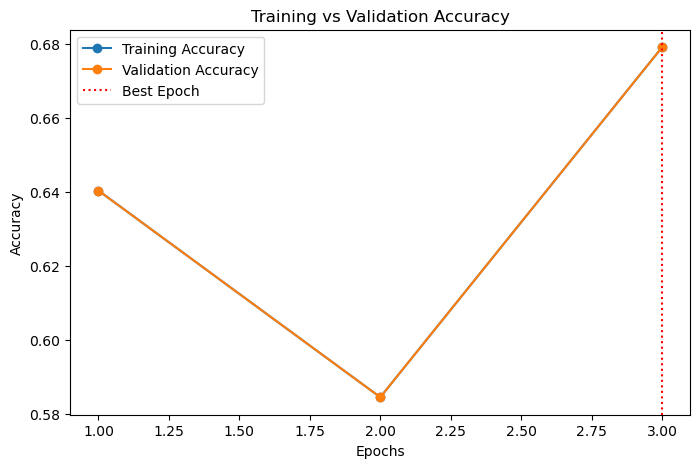

In [ ]:
# --- Extract logs efficiently ---
#logs = trainer.state.log_history

train_loss, val_loss, train_acc, val_acc, epochs = [], [], [], [], []

for log in logs:
    if "epoch" in log:
        if "loss" in log and "eval_loss" not in log:   # training loss only
            train_loss.append(log["loss"])
            epochs.append(log["epoch"])
        if "eval_loss" in log:                         # validation metrics
            val_loss.append(log["eval_loss"])
            val_acc.append(log["eval_accuracy"])
            # training accuracy at epoch (if logged)
            if "train_accuracy" in log:
                train_acc.append(log["train_accuracy"])

# If training accuracy wasn't logged, compute once at the end
if not train_acc:
    train_preds_output = trainer.predict(train_dataset)
    train_preds = np.argmax(train_preds_output.predictions, axis=-1)
    train_acc_value = accuracy_score(train_preds_output.label_ids, train_preds)
    train_acc = [train_acc_value] * len(val_acc)  # repeat for plotting

# --- Plot Loss ---
plt.figure(figsize=(8,5))
plt.plot(epochs, train_loss, label="Training Loss", marker="o")
plt.plot(epochs, val_loss, label="Validation Loss", marker="o")
best_epoch = np.argmin(val_loss)
plt.axvline(epochs[best_epoch], color="red", linestyle="dotted", label="Best Epoch")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Training vs Validation Loss")
plt.savefig("Training vs Validation Loss.png")
plt.show()

# --- Plot Accuracy ---
plt.figure(figsize=(8,5))
plt.plot(epochs, train_acc, label="Training Accuracy", marker="o")
plt.plot(epochs, val_acc, label="Validation Accuracy", marker="o")
best_epoch_acc = np.argmax(val_acc)
plt.axvline(epochs[best_epoch_acc], color="red", linestyle="dotted", label="Best Epoch")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Training vs Validation Accuracy")
plt.savefig("Training vs Validation Accuracy.png")
plt.show()


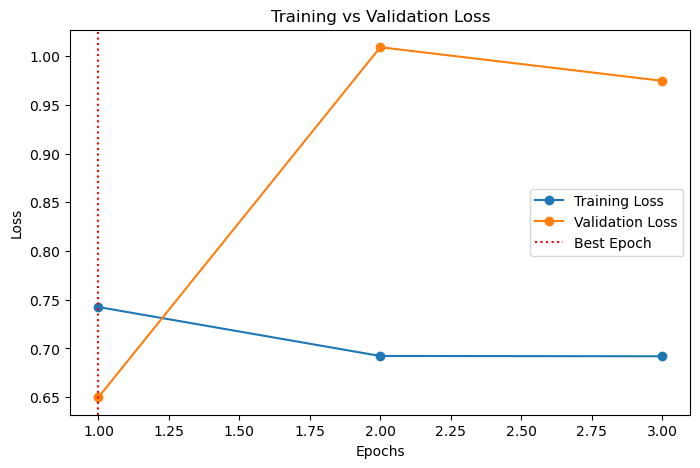

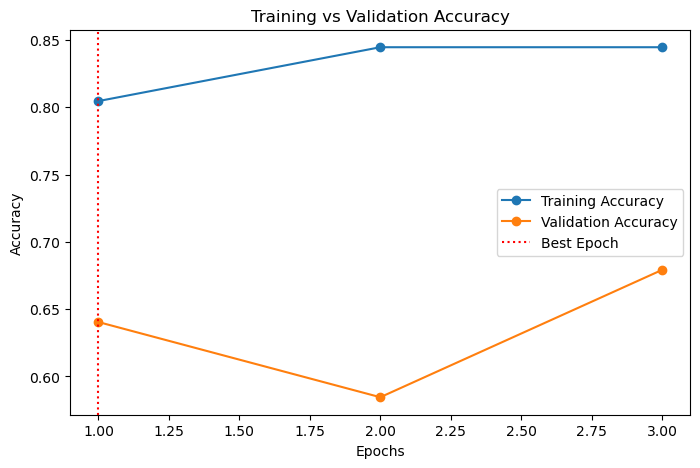

[0.804583, 0.844583, 0.844583] [0.6404166666666666, 0.5845833333333333, 0.6791666666666667]


In [25]:
import json
import matplotlib.pyplot as plt
import numpy as np

# --- Load logs ---
with open("training_logs.json", "r") as f:
    logs = json.load(f)

train_loss, val_loss, val_acc = [], [], []

# Extract metrics from logs
for log in logs:
    if "epoch" in log:
        if "loss" in log and "eval_loss" not in log:   # training loss only
            train_loss.append(log["loss"])
        if "eval_loss" in log:                         # validation metrics
            val_loss.append(log["eval_loss"])
            val_acc.append(log["eval_accuracy"])

# ✅ Define epochs explicitly (since we know it's 3)
epochs = [1, 2, 3]

# ✅ Manually add training accuracy (from your table)
train_acc = [0.804583, 0.844583, 0.844583]

# --- Plot Loss ---
plt.figure(figsize=(8,5))
plt.plot(epochs, train_loss, label="Training Loss", marker="o")
plt.plot(epochs, val_loss, label="Validation Loss", marker="o")
best_epoch = np.argmin(val_loss)
plt.axvline(epochs[best_epoch], color="red", linestyle="dotted", label="Best Epoch")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Training vs Validation Loss")
plt.savefig("Training_vs_Validation_Loss.png")
plt.show()

# --- Plot Accuracy ---
plt.figure(figsize=(8,5))
plt.plot(epochs, train_acc, label="Training Accuracy", marker="o")
plt.plot(epochs, val_acc, label="Validation Accuracy", marker="o")
plt.axvline(epochs[best_epoch], color="red", linestyle="dotted", label="Best Epoch")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Training vs Validation Accuracy")
plt.savefig("Training_vs_Validation_Accuracy.png")
plt.show()
print(train_acc, val_acc)


# Confusion Matrix on Test Set

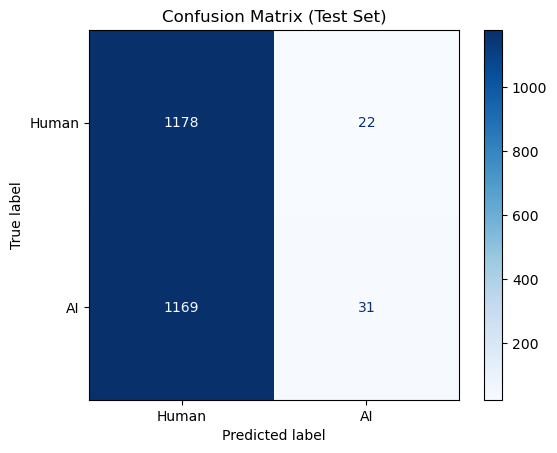

Classification Report (Test Set):

              precision    recall  f1-score   support

       Human     0.5019    0.9817    0.6642      1200
          AI     0.5849    0.0258    0.0495      1200

    accuracy                         0.5038      2400
   macro avg     0.5434    0.5038    0.3569      2400
weighted avg     0.5434    0.5038    0.3569      2400



In [26]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt
import numpy as np

# --- Make predictions on test set ---
preds_output = trainer.predict(test_dataset)

# Sometimes predictions come wrapped like (logits,) — handle both cases
logits = preds_output.predictions
if isinstance(logits, (tuple, list)):
    logits = logits[0]

# Now take argmax across the label dimension
preds = np.argmax(logits, axis=-1)

# --- Confusion Matrix ---
cm = confusion_matrix(test_labels, preds, labels=[0,1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Human","AI"])
disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix (Test Set)")
plt.savefig("confusion_matrix.png")
plt.show()

# --- Classification Report ---
report = classification_report(test_labels, preds, target_names=["Human", "AI"], digits=4)
print("Classification Report (Test Set):\n")
print(report)


In [7]:
# Save the final model and tokenizer
trainer.save_model("./mt5-small_model")  # Saves model + config
tokenizer.save_pretrained("./mt5-small_tokenizer")  # Saves tokenizer files


('./mt5-small_tokenizer\\tokenizer_config.json',
 './mt5-small_tokenizer\\special_tokens_map.json',
 './mt5-small_tokenizer\\spiece.model',
 './mt5-small_tokenizer\\added_tokens.json',
 './mt5-small_tokenizer\\tokenizer.json')

# About Model

In [27]:
# --- Model info ---
from transformers import AutoConfig

# Print model architecture
print("\nModel architecture:")
print(model)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"\nTotal parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")
print(f"Non-trainable parameters: {total_params - trainable_params:,}")

# Print model configuration
config = AutoConfig.from_pretrained("google/mt5-small")
print("\nModel configuration:")
print(config)



Model architecture:
T5ForSequenceClassification(
  (transformer): T5Model(
    (shared): Embedding(250112, 512)
    (encoder): T5Stack(
      (embed_tokens): Embedding(250112, 512)
      (block): ModuleList(
        (0): T5Block(
          (layer): ModuleList(
            (0): T5LayerSelfAttention(
              (SelfAttention): T5Attention(
                (q): Linear(in_features=512, out_features=384, bias=False)
                (k): Linear(in_features=512, out_features=384, bias=False)
                (v): Linear(in_features=512, out_features=384, bias=False)
                (o): Linear(in_features=384, out_features=512, bias=False)
                (relative_attention_bias): Embedding(32, 6)
              )
              (layer_norm): T5LayerNorm()
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (1): T5LayerFF(
              (DenseReluDense): T5DenseGatedActDense(
                (wi_0): Linear(in_features=512, out_features=1024, bias=False)
       

In [28]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline

# Paths where you saved the model + tokenizer
model_path = "./mt5-small_model"
tokenizer_path = "./mt5-small_tokenizer"

# Load tokenizer & model
tokenizer = AutoTokenizer.from_pretrained(tokenizer_path)
model = AutoModelForSequenceClassification.from_pretrained(
    model_path,
    id2label={0: "Human", 1: "AI"},
    label2id={"Human": 0, "AI": 1}
)

# Create pipeline for inference
classifier = pipeline("text-classification", model=model, tokenizer=tokenizer)

# --- Test a random text ---
test_text = "এই লেখাটি কৃত্রিম বুদ্ধিমত্তা দ্বারা লেখা হয়েছে।"
result = classifier(test_text)

print("Input:", test_text)
print("Prediction:", result)


Input: এই লেখাটি কৃত্রিম বুদ্ধিমত্তা দ্বারা লেখা হয়েছে।
Prediction: [{'label': 'Human', 'score': 0.9870054721832275}]
